# 2. Physics Informed Neural Networks

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [88]:
device = torch.device('cuda:3')

# Dataset generation

# 1. 2D Rectangular grid

In [89]:
Nx = 20                                                  # Number of samples
Ny = 20                                                   # Number of samples
x = torch.linspace(0, 1, Nx)                          # Input data for x (N x 1)
y = torch.linspace(0, 1, Ny)                          # Input data for y (N x 1)
xy = torch.meshgrid(x,y)                              # Meshgrid of x and y
xy_grid = torch.cat([xy[0].reshape(-1,1), xy[1].reshape(-1,1)],dim=1)

x_bdry = xy_grid[torch.logical_or((xy_grid[:,0]==1), (xy_grid[:,0]==0))]
y_bdry = xy_grid[torch.logical_or((xy_grid[:,1]==1), (xy_grid[:,1]==0))]
xy_bdry = torch.cat([x_bdry, y_bdry])
u_bdry = torch.zeros_like(xy_bdry[:,0]*xy_bdry[:,1]).view(-1,1)

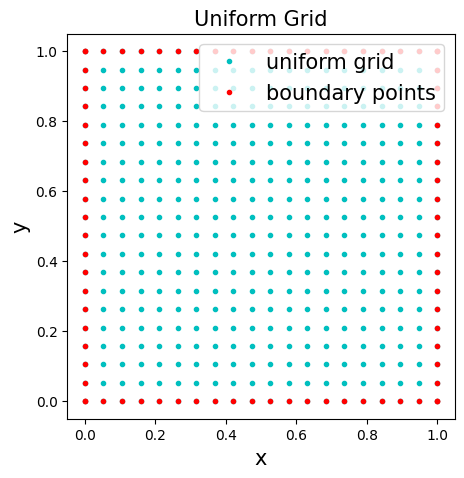

In [90]:
plt.figure(figsize=(5,5))
plt.plot(xy_grid[:,0], xy_grid[:,1], 'co', markersize=3, label='uniform grid')
plt.plot(xy_bdry[:,0], xy_bdry[:,1], 'ro', markersize=3, label='boundary points')
plt.legend(loc='upper right', fontsize=15)
plt.title('Uniform Grid', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.savefig('drm_data')

# Neural Network

In [91]:
# Build a neural network

class model(nn.Module) :
    def __init__(self, hidden_dims) :                    # Hidden_dims : [h1, h2, h3, ..., hn]
        super(model, self).__init__()
        
        self.layers = [nn.Linear(hidden_dims[0], hidden_dims[1])]
        for i in range(1,len(hidden_dims)-2) :
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
        self.layers.append(nn.Linear(hidden_dims[i+1], hidden_dims[-1]))
        self.layers = nn.ModuleList(self.layers)
        
        for layer in self.layers :                       # Weight initialization
            nn.init.xavier_uniform_(layer.weight)        # Also known as Glorot initialization
        
        self.act = nn.GELU()
    
    def forward(self, x) :
        x = self.act(self.layers[0](x))
        for layer in self.layers[1:-1] :
            y = self.act(layer(x))
            x = self.act(layer(y)) + x
        x = self.layers[-1](x)
        return x

# Loss function, Optimizer, Additional Parameters

In [138]:
# Prepare for training

network = model(hidden_dims=[2,64,64,1]).to(device)       # Pass the network to GPU
xy_grid = xy_grid.to(device).requires_grad_(True)             # Pass data to GPU
xy_bdry = xy_bdry.to(device)                                   # Pass data to GPU
u_bdry = u_bdry.to(device)  
x, y = x.to(device), y.to(device)  
loss_f = nn.MSELoss()                                  # Mean Square Error loss function
optimizer = optim.Adam(network.parameters(), lr=1e-3)  # Adam optimizer
EPOCHS = 20000                                         # Number of Training Iterations

In [139]:
def derivative(y, t) : 
    return torch.autograd.grad(y, t, create_graph=True,\
                               grad_outputs=torch.ones(y.size()).to(device))[0] 

# Mollifier

In [140]:
import math
from scipy.integrate import quad

def gaussian(x, sigma):
    if type(x) == torch.Tensor:
        valid_values = torch.exp(-x**2 / (2 * sigma**2)) / (sigma * math.sqrt(2 * math.pi))
        return valid_values

    else:
        return math.exp(-x**2 / (2 * sigma**2)) / (sigma * math.sqrt(2 * math.pi)) 

def bump(x,a=1.0):
    if type(x) == torch.Tensor:
        condition = (x.abs() < a)
        valid_values = torch.exp(-x**2 / a**2*(a**2 - x**2))  
        result = torch.where(condition, valid_values, torch.zeros_like(x)) 
        return result
    else:
        if abs(x) < a: return math.exp(x**2/a**2* (a**2 - x**2)) 
        else: return 0.0

def normalized_bump(x,a=1.0):
    integral, _ = quad(lambda x: bump(x,a), -a, a)
    coefficient = 1 / integral
    return coefficient * bump(x,a)

# Parameters

In [141]:
# parameters in the PDE
k = 1
sigma = 1/Nx
mollifier = lambda x: gaussian(x, sigma)

# Training

In [148]:
# Train
beta = 1
loss_list = []
network.train()
EPOCHS= 20000
x_2 = torch.tensor(0.3)
y_2 = torch.tensor(0.7)

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()
    output = network(xy_grid)
    output_bdry = network(xy_bdry)
    grad_output = derivative(output, xy_grid)
    
    integrand = (0.5*torch.norm(grad_output, dim=1)**2).view(-1,1) \
              + (0.5*(k*output)**2).view(-1,1) \
              - mollifier(torch.sqrt((xy_grid[:,0] - x_2)**2 + (xy_grid[:,1] - y_2)**2))*output
    integrand_bdry = (output_bdry-u_bdry)**2
    
    loss_ge = integrand.mean()#torch.trapz(torch.trapz(integrand.view(Nx,Ny), x), y) 
    loss_bdry = integrand_bdry.sum() * (1/Nx)
    
    loss = loss_ge + beta * loss_bdry
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if (not i % EPOCHS/20) or True:
        print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_bdry : %8.7f' %(i, EPOCHS, loss_ge.item(), loss_bdry.item()))
        clear_output(wait=True)
    if not i % EPOCHS/2 :torch.save(network, 'DRM_d=2.pt')
print('Training Finished.')


Training Finished.


In [149]:
torch.save(network, 'DRM_d=2.pt')
network = torch.load('DRM_d=2.pt', map_location=device)
pred = network(xy_grid)

In [150]:
torch.save(network, 'model_DRM_d=2.pt')

In [151]:
def eigenvalue(nx, ny):
    return (nx**2 + ny**2)*torch.pi**2 + k**2

def eigenfunction(x, y, nx, ny):
    return 2*torch.sin(nx*torch.pi*x.clone().detach())*torch.sin(ny*torch.pi*y.clone().detach())

def true_green(x, y, x_2, y_2):
    N_cutoff = 100
    value = 0
    for n_x in range(1, N_cutoff):
        for n_y in range(1, N_cutoff):
            value = value + eigenfunction(x, y, n_x, n_y)*eigenfunction(x_2, y_2, n_x, n_y)/eigenvalue(n_x, n_y)

    return value.clone().detach()

xy_detach = xy_grid.cpu().detach()
xx = xy_detach[:,0]
yy = xy_detach[:,1]

true = true_green(xx, yy, x_2, y_2)

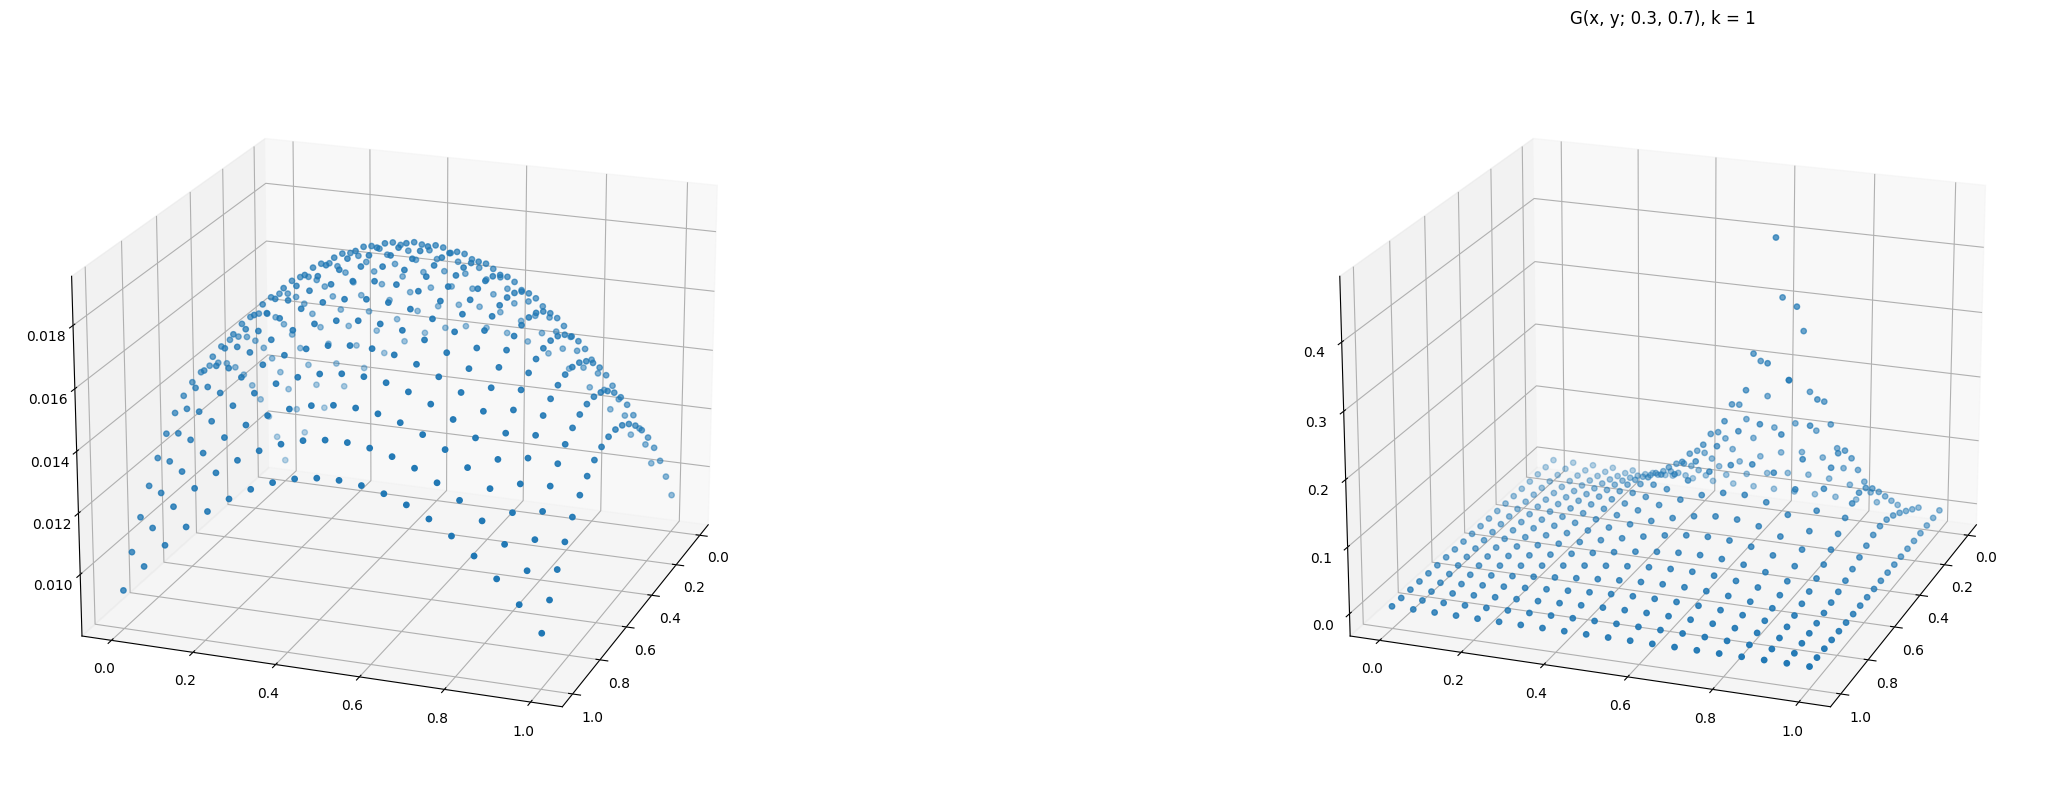

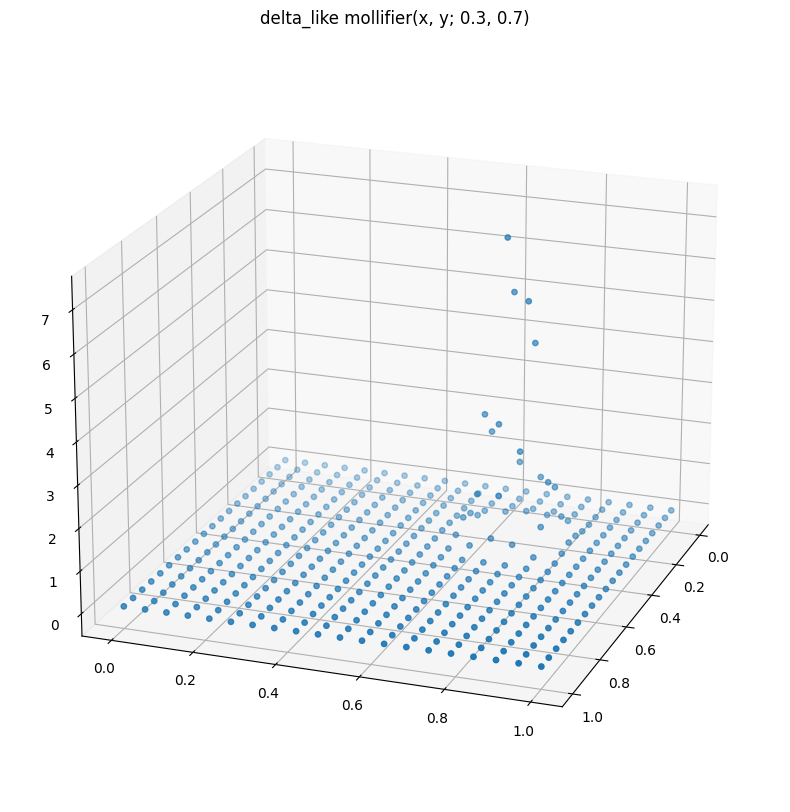

In [152]:
sizeparam = 10
fig = plt.figure(figsize=(sizeparam*3,sizeparam))

z_detach = pred.cpu().detach()
zz = z_detach

# find argmax index of zz
#idx = torch.argmax(zz)
ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=20., azim=20)
#ax.scatter(xx[idx], yy[idx], zz[idx], c='red', label = f"min value: {zz[idx]} at {(xx[idx], yy[idx])}")
ax.scatter(xx, yy, zz, s=15)
#ax.legend()

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=20., azim=20)
ax.scatter(xx, yy, true, s=15)
plt.title("G(x, y; 0.3, 0.7), k = 1")
plt.show()

output = {"grid": xy_detach, "prediction": z_detach}
#torch.save(obj=output, f = "/product/CAC2023/cac030/KIAS-AI-GROUP-7/" + "output_dict_DRM_d=2.pt")
#did not converge


sizeparam = 10
fig = plt.figure(figsize=(sizeparam*3,sizeparam))
delta = mollifier(((xx - x_2)**2 + (yy - y_2)**2).sqrt())
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20., azim=20)
ax.scatter(xx, yy, delta, s=15)
plt.title("delta_like mollifier(x, y; 0.3, 0.7)")
plt.show()

In [153]:
print('Mean Square Error is : %8.7f' % F.mse_loss(pred[:,0], true.to(device)).item())

Mean Square Error is : 0.0048679


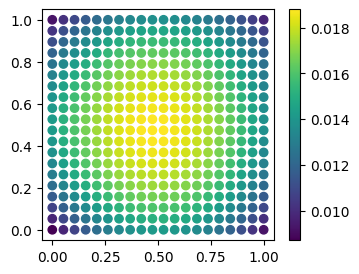

In [157]:
sizeparam = 3*Nx/20
plt.figure(figsize=(1.25*sizeparam,sizeparam))

plt.scatter(xx, yy, c = zz)
plt.colorbar()
plt.show()